![](https://raw.githubusercontent.com/OYBDOOO/oss/master/uPic/BSgd0b.png)

In [78]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [79]:
g = 9.8                  # 重力加速度 m/s^2
omega = 7.292e-5         # 地球自转角速度 rad/s
deg2rad = np.pi / 180
dy = 111e3 * 5           # 5° 纬度间距约 111 km/° * 5 = 555 km
dx = 111e3 * 5           # 近似经度间距（低纬度可略去 cosφ）

In [92]:
data = np.loadtxt("Zuv.dat")
flat = data.flatten()
print(flat[0:nx*ny])
print(flat[0:nx*ny].reshape(nx, ny))

[6339.62 6344.43 6349.77 6389.12 6360.56 6336.74 6409.44 6503.96 6338.81
 6354.98 6349.39 6348.11 6346.62 6320.34 6374.15 6456.49 6350.09 6343.36
 6347.18 6346.32 6337.62 6314.09 6284.8  6259.82 6338.2  6342.24 6345.89
 6344.54 6335.54 6311.54 6276.51 6243.75 6337.89 6341.51 6344.6  6342.77
 6333.46 6316.01 6274.94 6221.74 6337.58 6340.79 6343.32 6340.99 6331.39
 6306.47 6264.78 6213.97 6337.28 6340.07 6342.04 6339.23 6329.33 6303.94
 6261.36 6209.38 6336.97 6339.35 6340.77 6337.47 6327.28 6301.43 6257.95
 6204.8  6336.67 6338.63 6339.5  6335.71 6325.23 6298.92 6254.54 6200.23
 6336.37 6337.91 6338.23 6333.96 6323.19 6296.42 6251.14 6195.66 6336.06
 6337.2  6336.96 6332.22 6321.15 6293.93 6247.75 6191.1  6335.76 6336.49
 6335.7  6330.48 6319.12 6291.45 6244.38 6186.54]
[[6339.62 6344.43 6349.77 6389.12 6360.56 6336.74 6409.44 6503.96]
 [6338.81 6354.98 6349.39 6348.11 6346.62 6320.34 6374.15 6456.49]
 [6350.09 6343.36 6347.18 6346.32 6337.62 6314.09 6284.8  6259.82]
 [6338.2  6342.24 6

In [81]:
nx, ny = 12, 8
Z = flat[0:nx*ny].reshape(nx, ny).T
u = flat[nx*ny:2*nx*ny].reshape(nx, ny).T
v = flat[2*nx*ny:3*nx*ny].reshape(nx, ny).T



南端(10N) Z: [6339.62 6338.81 6350.09 6338.2  6337.89]
北端(45N) Z: [6339.62 6338.81 6350.09 6338.2  6337.89]


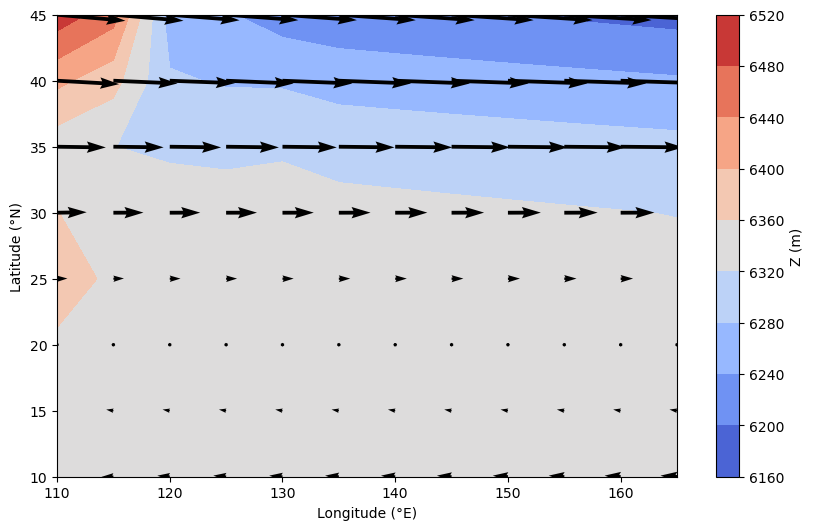

In [82]:

lat = np.linspace(10, 45, ny)   # 8格
lon = np.linspace(110, 165, nx) # 12格
Lon, Lat = np.meshgrid(lon, lat)
# print(Z)
print("南端(10N) Z:", Z[0, :5])
print("北端(45N) Z:", Z[0, :5])


plt.figure(figsize=(10, 6))
plt.contourf(Lon, Lat, Z, cmap='coolwarm')
plt.colorbar(label='Z (m)')
plt.quiver(Lon, Lat, u, v, color='k')
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.show()

In [83]:
lat = np.linspace(10, 45, ny)  # 10°N ~ 45°N
lon = np.linspace(110, 165, nx)
f = 2 * omega * np.sin(lat * deg2rad)  # f 随纬度变化

dZdy = np.zeros_like(Z)
dZdx = np.zeros_like(Z)

for j in range(1, ny-1):
    dZdy[j, :] = (Z[j+1, :] - Z[j-1, :]) / (2*dy)
for i in range(1, nx-1):
    dZdx[:, i] = (Z[:, i+1] - Z[:, i-1]) / (2*dx)

# 边界点采用一阶差分
dZdy[0, :] = (Z[1, :] - Z[0, :]) / dy
dZdy[-1, :] = (Z[-1, :] - Z[-2, :]) / dy
dZdx[:, 0] = (Z[:, 1] - Z[:, 0]) / dx
dZdx[:, -1] = (Z[:, -1] - Z[:, -2]) / dx

# 计算地转风
ug = np.zeros_like(Z)
vg = np.zeros_like(Z)
for j in range(ny):
    ug[j, :] = -g / f[j] * dZdy[j, :]
    vg[j, :] =  g / f[j] * dZdx[j, :]


In [87]:
div = np.zeros_like(Z)
vor = np.zeros_like(Z)

for j in range(ny):
    for i in range(nx):
        # dudx
        if i == 0:
            dudx = (u[j, i+1] - u[j, i]) / dx
        elif i == nx-1:
            dudx = (u[j, i] - u[j, i-1]) / dx
        else:
            dudx = (u[j, i+1] - u[j, i-1]) / (2*dx)

        # dvdy
        if j == 0:
            dvdy = (v[j+1, i] - v[j, i]) / dy
        elif j == ny-1:
            dvdy = (v[j, i] - v[j-1, i]) / dy
        else:
            dvdy = (v[j+1, i] - v[j-1, i]) / (2*dy)

        div[j, i] = dudx + dvdy

        # dvdx
        if i == 0:
            dvdx = (v[j, i+1] - v[j, i]) / dx
        elif i == nx-1:
            dvdx = (v[j, i] - v[j, i-1]) / dx
        else:
            dvdx = (v[j, i+1] - v[j, i-1]) / (2*dx)

        # dudy
        if j == 0:
            dudy = (u[j+1, i] - u[j, i]) / dy
        elif j == ny-1:
            dudy = (u[j, i] - u[j-1, i]) / dy
        else:
            dudy = (u[j+1, i] - u[j-1, i]) / (2*dy)

        vor[j, i] = dvdx - dudy


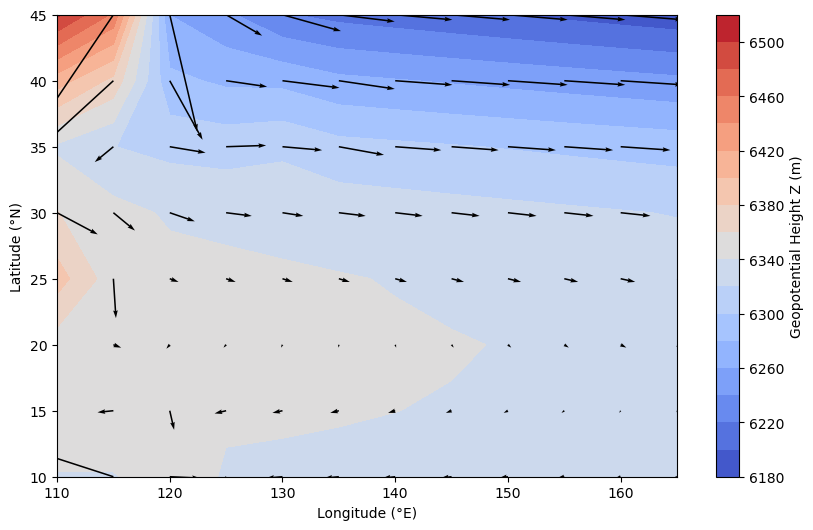

In [88]:
Lon, Lat = np.meshgrid(lon, lat)
plt.figure(figsize=(10, 6))
cont = plt.contourf(Lon, Lat, Z, cmap='coolwarm', levels=20)
plt.colorbar(cont, label='Geopotential Height Z (m)')

Q = plt.quiver(Lon, Lat, ug, vg,  width=0.0025, color='k')
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.show()

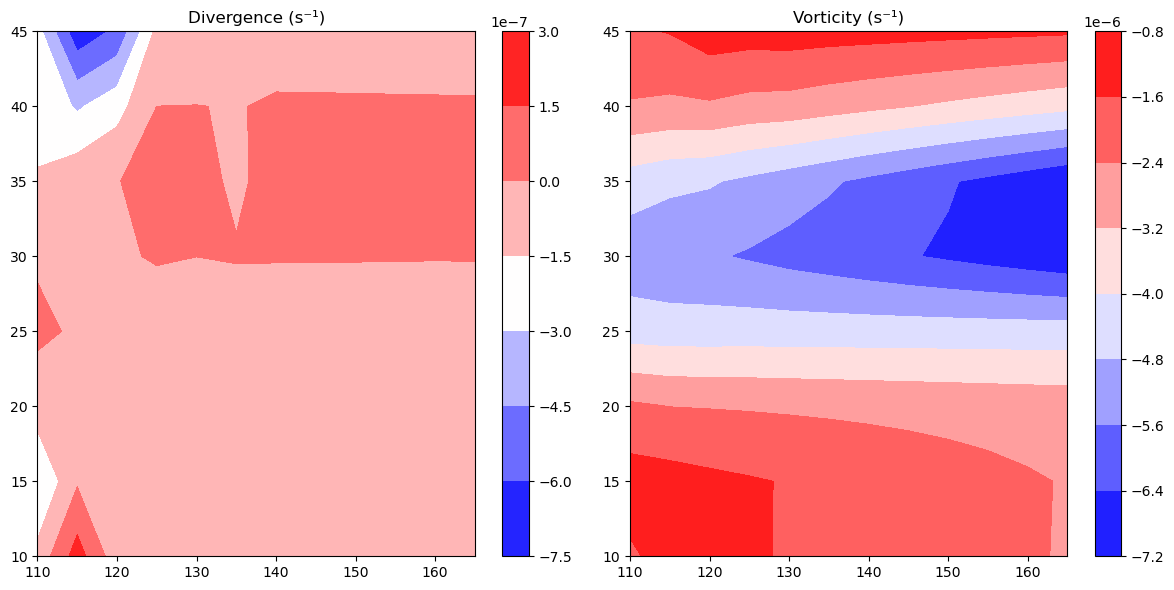

In [94]:
Lon, Lat = np.meshgrid(lon, lat)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))



# 散度
cs3 = axs[0].contourf(Lon, Lat, div, cmap='bwr')

axs[0].set_title("Divergence (s⁻¹)")
plt.colorbar(cs3, ax=axs[0])

# 涡度
cs4 = axs[1].contourf(Lon, Lat, vor, cmap='bwr')
axs[1].set_title("Vorticity (s⁻¹)")
plt.colorbar(cs4, ax=axs[1])

plt.tight_layout()
plt.show()


In [95]:
vorg = np.zeros_like(Z)

for j in range(ny):
    for i in range(nx):

        # dvdx
        if i == 0:
            dvdx = (vg[j, i+1] - vg[j, i]) / dx
        elif i == nx-1:
            dvdx = (vg[j, i] - vg[j, i-1]) / dx
        else:
            dvdx = (vg[j, i+1] - vg[j, i-1]) / (2*dx)

        # dudy
        if j == 0:
            dudy = (ug[j+1, i] - ug[j, i]) / dy
        elif j == ny-1:
            dudy = (ug[j, i] - ug[j-1, i]) / dy
        else:
            dudy = (ug[j+1, i] - ug[j-1, i]) / (2*dy)

        vorg[j, i] = dvdx - dudy

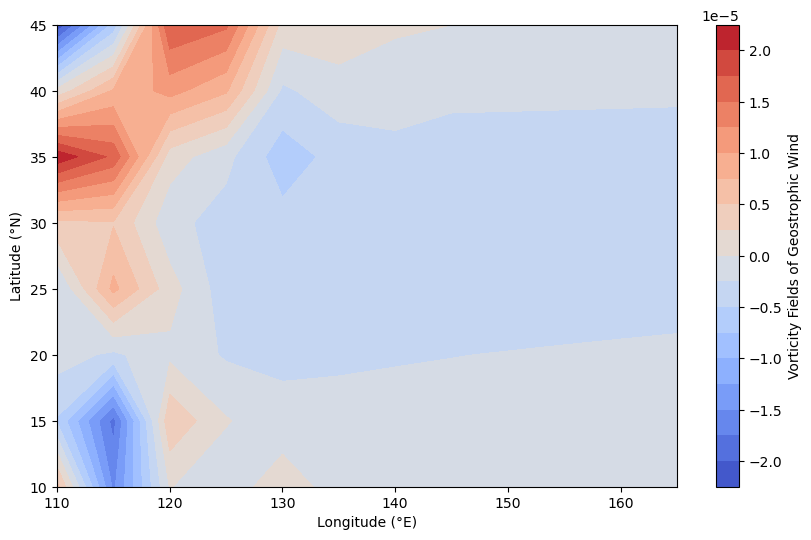

In [97]:
Lon, Lat = np.meshgrid(lon, lat)
plt.figure(figsize=(10, 6))
cont = plt.contourf(Lon, Lat, vorg, cmap='coolwarm', levels=20)
plt.colorbar(cont, label='Vorticity Fields of Geostrophic Wind')

plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.show()